In [37]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [38]:
# Load the data
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

# Scale data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

# Split into train and test
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [39]:
# Drop 95% of the labels from the training set
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

C:\Users\ankur_\Anaconda3\envs\unsupervisedLearning\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [40]:
# Define evaluation function and plotting function

In [41]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [42]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [43]:
# Define new function to assess precision at a given recall threshold

In [44]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [45]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [46]:
# Supervised

In [47]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [48]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00516281
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00199983
[3]	valid_0's binary_logloss: 0.00235712
[4]	valid_0's binary_logloss: 0.00234997
[5]	valid_0's binary_logloss: 0.00230526
[6]	valid_0's binary_logloss: 0.00226783
[7]	valid_0's binary_logloss: 0.00223639
[8]	valid_0's binary_logloss: 0.00221215
[9]	valid_0's binary_logloss: 0.00218928
[10]	valid_0's binary_logloss: 0.00217154
[11]	valid_0's binary_logloss: 0.00215385
[12]	valid_0's binary_logloss: 0.00214024
[13]	valid_0's binary_logloss: 0.00212557
[14]	valid_0's binary_logloss: 0.00211323
[15]	valid_0's binary_logloss: 0.00210066
[16]	valid_0's binary_logloss: 0.00209014
[17]	valid_0's binary_logloss: 0.00207927
[18]	valid_0's binary_logloss: 0.00206909
[19]	valid_0's binary_logloss: 0.00205901
[20]	valid_0's binary_logloss: 0.00205012
[21]	valid_0's binary_logloss: 0.00204114
[22]	valid_0's binary_logloss: 0.00203291
[23]	valid_0's binary_

[196]	valid_0's binary_logloss: 0.00166407
[197]	valid_0's binary_logloss: 0.00166349
[198]	valid_0's binary_logloss: 0.00166314
[199]	valid_0's binary_logloss: 0.00166278
[200]	valid_0's binary_logloss: 0.00166222
[201]	valid_0's binary_logloss: 0.00166171
[202]	valid_0's binary_logloss: 0.00166196
[203]	valid_0's binary_logloss: 0.00166143
[204]	valid_0's binary_logloss: 0.00166112
[205]	valid_0's binary_logloss: 0.00166079
[206]	valid_0's binary_logloss: 0.00166028
[207]	valid_0's binary_logloss: 0.00165946
[208]	valid_0's binary_logloss: 0.00165859
[209]	valid_0's binary_logloss: 0.00165748
[210]	valid_0's binary_logloss: 0.00165638
[211]	valid_0's binary_logloss: 0.00165553
[212]	valid_0's binary_logloss: 0.00165389
[213]	valid_0's binary_logloss: 0.00165361
[214]	valid_0's binary_logloss: 0.00165256
[215]	valid_0's binary_logloss: 0.00165113
[216]	valid_0's binary_logloss: 0.00165045
[217]	valid_0's binary_logloss: 0.00164886
[218]	valid_0's binary_logloss: 0.00164788
[219]	valid

[397]	valid_0's binary_logloss: 0.00155286
[398]	valid_0's binary_logloss: 0.00155301
[399]	valid_0's binary_logloss: 0.00155329
[400]	valid_0's binary_logloss: 0.00155344
[401]	valid_0's binary_logloss: 0.00155381
[402]	valid_0's binary_logloss: 0.00155397
[403]	valid_0's binary_logloss: 0.00155364
[404]	valid_0's binary_logloss: 0.00155393
[405]	valid_0's binary_logloss: 0.00155409
[406]	valid_0's binary_logloss: 0.00155445
[407]	valid_0's binary_logloss: 0.00155413
[408]	valid_0's binary_logloss: 0.00155451
[409]	valid_0's binary_logloss: 0.00155432
[410]	valid_0's binary_logloss: 0.0015547
[411]	valid_0's binary_logloss: 0.00155439
[412]	valid_0's binary_logloss: 0.00155421
[413]	valid_0's binary_logloss: 0.00155462
[414]	valid_0's binary_logloss: 0.00155503
[415]	valid_0's binary_logloss: 0.0015556
[416]	valid_0's binary_logloss: 0.00155543
[417]	valid_0's binary_logloss: 0.00155585
[418]	valid_0's binary_logloss: 0.00155635
[419]	valid_0's binary_logloss: 0.00155596
[420]	valid_0

[608]	valid_0's binary_logloss: 0.00158017
[609]	valid_0's binary_logloss: 0.00158103
[610]	valid_0's binary_logloss: 0.00158051
[611]	valid_0's binary_logloss: 0.00158133
[612]	valid_0's binary_logloss: 0.0015823
[613]	valid_0's binary_logloss: 0.00158316
[614]	valid_0's binary_logloss: 0.00158294
[615]	valid_0's binary_logloss: 0.0015838
[616]	valid_0's binary_logloss: 0.00158459
[617]	valid_0's binary_logloss: 0.00158408
[618]	valid_0's binary_logloss: 0.00158479
[619]	valid_0's binary_logloss: 0.00158428
[620]	valid_0's binary_logloss: 0.00158378
[621]	valid_0's binary_logloss: 0.00158356
[622]	valid_0's binary_logloss: 0.0015844
[623]	valid_0's binary_logloss: 0.00158522
[624]	valid_0's binary_logloss: 0.00158501
[625]	valid_0's binary_logloss: 0.0015858
[626]	valid_0's binary_logloss: 0.0015853
[627]	valid_0's binary_logloss: 0.00158609
[628]	valid_0's binary_logloss: 0.00158559
[629]	valid_0's binary_logloss: 0.00158515
[630]	valid_0's binary_logloss: 0.00158599
[631]	valid_0's 

[85]	valid_0's binary_logloss: 0.00313394
[86]	valid_0's binary_logloss: 0.00312851
[87]	valid_0's binary_logloss: 0.00312236
[88]	valid_0's binary_logloss: 0.00311643
[89]	valid_0's binary_logloss: 0.00311086
[90]	valid_0's binary_logloss: 0.00310495
[91]	valid_0's binary_logloss: 0.00310088
[92]	valid_0's binary_logloss: 0.00309489
[93]	valid_0's binary_logloss: 0.00308963
[94]	valid_0's binary_logloss: 0.00308562
[95]	valid_0's binary_logloss: 0.00308006
[96]	valid_0's binary_logloss: 0.0030751
[97]	valid_0's binary_logloss: 0.00306962
[98]	valid_0's binary_logloss: 0.00306386
[99]	valid_0's binary_logloss: 0.00306
[100]	valid_0's binary_logloss: 0.00305442
[101]	valid_0's binary_logloss: 0.0030488
[102]	valid_0's binary_logloss: 0.00304195
[103]	valid_0's binary_logloss: 0.00303657
[104]	valid_0's binary_logloss: 0.00303082
[105]	valid_0's binary_logloss: 0.00302575
[106]	valid_0's binary_logloss: 0.00301989
[107]	valid_0's binary_logloss: 0.00301506
[108]	valid_0's binary_logloss:

[83]	valid_0's binary_logloss: 0.00187226
[84]	valid_0's binary_logloss: 0.00187139
[85]	valid_0's binary_logloss: 0.00187056
[86]	valid_0's binary_logloss: 0.00186942
[87]	valid_0's binary_logloss: 0.0018679
[88]	valid_0's binary_logloss: 0.00186617
[89]	valid_0's binary_logloss: 0.00186411
[90]	valid_0's binary_logloss: 0.00186209
[91]	valid_0's binary_logloss: 0.0018601
[92]	valid_0's binary_logloss: 0.00185813
[93]	valid_0's binary_logloss: 0.00185614
[94]	valid_0's binary_logloss: 0.00185417
[95]	valid_0's binary_logloss: 0.00185223
[96]	valid_0's binary_logloss: 0.0018503
[97]	valid_0's binary_logloss: 0.00184841
[98]	valid_0's binary_logloss: 0.00184654
[99]	valid_0's binary_logloss: 0.0018447
[100]	valid_0's binary_logloss: 0.00184336
[101]	valid_0's binary_logloss: 0.00184155
[102]	valid_0's binary_logloss: 0.00184024
[103]	valid_0's binary_logloss: 0.00183894
[104]	valid_0's binary_logloss: 0.00183767
[105]	valid_0's binary_logloss: 0.00183641
[106]	valid_0's binary_logloss: 

[275]	valid_0's binary_logloss: 0.00174198
[276]	valid_0's binary_logloss: 0.00174282
[277]	valid_0's binary_logloss: 0.00174287
[278]	valid_0's binary_logloss: 0.00174367
[279]	valid_0's binary_logloss: 0.00174459
[280]	valid_0's binary_logloss: 0.00174471
[281]	valid_0's binary_logloss: 0.00174558
[282]	valid_0's binary_logloss: 0.00174472
[283]	valid_0's binary_logloss: 0.00174478
[284]	valid_0's binary_logloss: 0.00174572
[285]	valid_0's binary_logloss: 0.00174666
[286]	valid_0's binary_logloss: 0.00174681
[287]	valid_0's binary_logloss: 0.00174598
[288]	valid_0's binary_logloss: 0.00174606
[289]	valid_0's binary_logloss: 0.00174701
[290]	valid_0's binary_logloss: 0.00174797
[291]	valid_0's binary_logloss: 0.00174814
[292]	valid_0's binary_logloss: 0.00174927
[293]	valid_0's binary_logloss: 0.00175023
[294]	valid_0's binary_logloss: 0.00175033
[295]	valid_0's binary_logloss: 0.0017513
[296]	valid_0's binary_logloss: 0.00175149
[297]	valid_0's binary_logloss: 0.00175246
[298]	valid_

[61]	valid_0's binary_logloss: 0.00260008
[62]	valid_0's binary_logloss: 0.00259713
[63]	valid_0's binary_logloss: 0.00264236
[64]	valid_0's binary_logloss: 0.00263911
[65]	valid_0's binary_logloss: 0.00263592
[66]	valid_0's binary_logloss: 0.00263227
[67]	valid_0's binary_logloss: 0.00262917
[68]	valid_0's binary_logloss: 0.00262702
[69]	valid_0's binary_logloss: 0.00262403
[70]	valid_0's binary_logloss: 0.00262446
[71]	valid_0's binary_logloss: 0.00262101
[72]	valid_0's binary_logloss: 0.00261986
[73]	valid_0's binary_logloss: 0.00261628
[74]	valid_0's binary_logloss: 0.00261351
[75]	valid_0's binary_logloss: 0.00261004
[76]	valid_0's binary_logloss: 0.00260766
[77]	valid_0's binary_logloss: 0.00260427
[78]	valid_0's binary_logloss: 0.0026042
[79]	valid_0's binary_logloss: 0.00260115
[80]	valid_0's binary_logloss: 0.00259814
[81]	valid_0's binary_logloss: 0.00259517
[82]	valid_0's binary_logloss: 0.00259225
[83]	valid_0's binary_logloss: 0.00258967
[84]	valid_0's binary_logloss: 0.00

[261]	valid_0's binary_logloss: 0.00233673
[262]	valid_0's binary_logloss: 0.00233626
[263]	valid_0's binary_logloss: 0.00233577
[264]	valid_0's binary_logloss: 0.00233471
[265]	valid_0's binary_logloss: 0.00233436
[266]	valid_0's binary_logloss: 0.00233332
[267]	valid_0's binary_logloss: 0.00233286
[268]	valid_0's binary_logloss: 0.0023324
[269]	valid_0's binary_logloss: 0.00233139
[270]	valid_0's binary_logloss: 0.00233099
[271]	valid_0's binary_logloss: 0.00232999
[272]	valid_0's binary_logloss: 0.00232956
[273]	valid_0's binary_logloss: 0.00232927
[274]	valid_0's binary_logloss: 0.00232838
[275]	valid_0's binary_logloss: 0.00232777
[276]	valid_0's binary_logloss: 0.00232721
[277]	valid_0's binary_logloss: 0.00232635
[278]	valid_0's binary_logloss: 0.00232596
[279]	valid_0's binary_logloss: 0.00232538
[280]	valid_0's binary_logloss: 0.00232454
[281]	valid_0's binary_logloss: 0.00232442
[282]	valid_0's binary_logloss: 0.00232406
[283]	valid_0's binary_logloss: 0.00232323
[284]	valid_

[472]	valid_0's binary_logloss: 0.00224984
[473]	valid_0's binary_logloss: 0.00225036
[474]	valid_0's binary_logloss: 0.00225089
[475]	valid_0's binary_logloss: 0.00225087
[476]	valid_0's binary_logloss: 0.00225146
[477]	valid_0's binary_logloss: 0.00225204
[478]	valid_0's binary_logloss: 0.00225263
[479]	valid_0's binary_logloss: 0.00225223
[480]	valid_0's binary_logloss: 0.00225278
[481]	valid_0's binary_logloss: 0.00225265
[482]	valid_0's binary_logloss: 0.00225213
[483]	valid_0's binary_logloss: 0.00225207
[484]	valid_0's binary_logloss: 0.00225221
[485]	valid_0's binary_logloss: 0.00225208
[486]	valid_0's binary_logloss: 0.00225208
[487]	valid_0's binary_logloss: 0.0022519
[488]	valid_0's binary_logloss: 0.00225178
[489]	valid_0's binary_logloss: 0.00225193
[490]	valid_0's binary_logloss: 0.00225209
[491]	valid_0's binary_logloss: 0.00225208
[492]	valid_0's binary_logloss: 0.00225191
[493]	valid_0's binary_logloss: 0.0022518
[494]	valid_0's binary_logloss: 0.00225176
[495]	valid_0

[26]	valid_0's binary_logloss: 0.00303248
[27]	valid_0's binary_logloss: 0.00302986
[28]	valid_0's binary_logloss: 0.00302488
[29]	valid_0's binary_logloss: 0.00302404
[30]	valid_0's binary_logloss: 0.00301214
[31]	valid_0's binary_logloss: 0.00299988
[32]	valid_0's binary_logloss: 0.00299556
[33]	valid_0's binary_logloss: 0.00299139
[34]	valid_0's binary_logloss: 0.00298983
[35]	valid_0's binary_logloss: 0.00298006
[36]	valid_0's binary_logloss: 0.00297319
[37]	valid_0's binary_logloss: 0.00297719
[38]	valid_0's binary_logloss: 0.00296736
[39]	valid_0's binary_logloss: 0.00296568
[40]	valid_0's binary_logloss: 0.00295555
[41]	valid_0's binary_logloss: 0.00295377
[42]	valid_0's binary_logloss: 0.00295493
[43]	valid_0's binary_logloss: 0.00294468
[44]	valid_0's binary_logloss: 0.00292847
[45]	valid_0's binary_logloss: 0.00291295
[46]	valid_0's binary_logloss: 0.00289842
[47]	valid_0's binary_logloss: 0.00288464
[48]	valid_0's binary_logloss: 0.00287169
[49]	valid_0's binary_logloss: 0.0

[227]	valid_0's binary_logloss: 0.001947
[228]	valid_0's binary_logloss: 0.00194447
[229]	valid_0's binary_logloss: 0.00194067
[230]	valid_0's binary_logloss: 0.00193817
[231]	valid_0's binary_logloss: 0.00193443
[232]	valid_0's binary_logloss: 0.00193346
[233]	valid_0's binary_logloss: 0.00193102
[234]	valid_0's binary_logloss: 0.0019286
[235]	valid_0's binary_logloss: 0.00192485
[236]	valid_0's binary_logloss: 0.00192184
[237]	valid_0's binary_logloss: 0.00192093
[238]	valid_0's binary_logloss: 0.00191859
[239]	valid_0's binary_logloss: 0.00191564
[240]	valid_0's binary_logloss: 0.00191334
[241]	valid_0's binary_logloss: 0.00191044
[242]	valid_0's binary_logloss: 0.00190818
[243]	valid_0's binary_logloss: 0.00190534
[244]	valid_0's binary_logloss: 0.00190312
[245]	valid_0's binary_logloss: 0.00190091
[246]	valid_0's binary_logloss: 0.00189814
[247]	valid_0's binary_logloss: 0.00189597
[248]	valid_0's binary_logloss: 0.00189414
[249]	valid_0's binary_logloss: 0.00189335
[250]	valid_0'

[422]	valid_0's binary_logloss: 0.0016937
[423]	valid_0's binary_logloss: 0.00169339
[424]	valid_0's binary_logloss: 0.00169288
[425]	valid_0's binary_logloss: 0.00169258
[426]	valid_0's binary_logloss: 0.00169228
[427]	valid_0's binary_logloss: 0.00169178
[428]	valid_0's binary_logloss: 0.00169149
[429]	valid_0's binary_logloss: 0.00169121
[430]	valid_0's binary_logloss: 0.00169043
[431]	valid_0's binary_logloss: 0.00169015
[432]	valid_0's binary_logloss: 0.00168988
[433]	valid_0's binary_logloss: 0.00168967
[434]	valid_0's binary_logloss: 0.00168933
[435]	valid_0's binary_logloss: 0.00168947
[436]	valid_0's binary_logloss: 0.00168979
[437]	valid_0's binary_logloss: 0.00169012
[438]	valid_0's binary_logloss: 0.00168965
[439]	valid_0's binary_logloss: 0.00168896
[440]	valid_0's binary_logloss: 0.00168821
[441]	valid_0's binary_logloss: 0.00168802
[442]	valid_0's binary_logloss: 0.00168773
[443]	valid_0's binary_logloss: 0.00168789
[444]	valid_0's binary_logloss: 0.00168761
[445]	valid_

[623]	valid_0's binary_logloss: 0.00162699
[624]	valid_0's binary_logloss: 0.00162703
[625]	valid_0's binary_logloss: 0.00162705
[626]	valid_0's binary_logloss: 0.00162662
[627]	valid_0's binary_logloss: 0.00162666
[628]	valid_0's binary_logloss: 0.00162643
[629]	valid_0's binary_logloss: 0.00162625
[630]	valid_0's binary_logloss: 0.00162641
[631]	valid_0's binary_logloss: 0.00162644
[632]	valid_0's binary_logloss: 0.00162617
[633]	valid_0's binary_logloss: 0.00162642
[634]	valid_0's binary_logloss: 0.00162525
[635]	valid_0's binary_logloss: 0.00162482
[636]	valid_0's binary_logloss: 0.00162488
[637]	valid_0's binary_logloss: 0.00162445
[638]	valid_0's binary_logloss: 0.00162451
[639]	valid_0's binary_logloss: 0.00162427
[640]	valid_0's binary_logloss: 0.00162409
[641]	valid_0's binary_logloss: 0.00162345
[642]	valid_0's binary_logloss: 0.00162323
[643]	valid_0's binary_logloss: 0.00162306
[644]	valid_0's binary_logloss: 0.00162312
[645]	valid_0's binary_logloss: 0.00162331
[646]	valid

[831]	valid_0's binary_logloss: 0.00157609
[832]	valid_0's binary_logloss: 0.00157726
[833]	valid_0's binary_logloss: 0.00157812
[834]	valid_0's binary_logloss: 0.00157813
[835]	valid_0's binary_logloss: 0.00157766
[836]	valid_0's binary_logloss: 0.00157851
[837]	valid_0's binary_logloss: 0.00157834
[838]	valid_0's binary_logloss: 0.00157836
[839]	valid_0's binary_logloss: 0.00157813
[840]	valid_0's binary_logloss: 0.00157766
[841]	valid_0's binary_logloss: 0.00157733
[842]	valid_0's binary_logloss: 0.00157753
[843]	valid_0's binary_logloss: 0.00157754
[844]	valid_0's binary_logloss: 0.00157677
[845]	valid_0's binary_logloss: 0.00157584
[846]	valid_0's binary_logloss: 0.00157497
[847]	valid_0's binary_logloss: 0.00157476
[848]	valid_0's binary_logloss: 0.0015739
[849]	valid_0's binary_logloss: 0.00157357
[850]	valid_0's binary_logloss: 0.00157475
[851]	valid_0's binary_logloss: 0.00157454
[852]	valid_0's binary_logloss: 0.00157369
[853]	valid_0's binary_logloss: 0.00157352
[854]	valid_

[1030]	valid_0's binary_logloss: 0.00155737
[1031]	valid_0's binary_logloss: 0.00155873
[1032]	valid_0's binary_logloss: 0.00155796
[1033]	valid_0's binary_logloss: 0.00155783
[1034]	valid_0's binary_logloss: 0.00155788
[1035]	valid_0's binary_logloss: 0.00155794
[1036]	valid_0's binary_logloss: 0.00155771
[1037]	valid_0's binary_logloss: 0.00155906
[1038]	valid_0's binary_logloss: 0.0015583
[1039]	valid_0's binary_logloss: 0.00155807
[1040]	valid_0's binary_logloss: 0.0015581
[1041]	valid_0's binary_logloss: 0.00155717
[1042]	valid_0's binary_logloss: 0.00155641
[1043]	valid_0's binary_logloss: 0.00155733
[1044]	valid_0's binary_logloss: 0.00155702
[1045]	valid_0's binary_logloss: 0.00155733
[1046]	valid_0's binary_logloss: 0.00155709
[1047]	valid_0's binary_logloss: 0.00155838
[1048]	valid_0's binary_logloss: 0.00155851
[1049]	valid_0's binary_logloss: 0.00155881
[1050]	valid_0's binary_logloss: 0.00155857
[1051]	valid_0's binary_logloss: 0.00155782
[1052]	valid_0's binary_logloss: 0

[1237]	valid_0's binary_logloss: 0.00162352
[1238]	valid_0's binary_logloss: 0.0016237
[1239]	valid_0's binary_logloss: 0.0016247
[1240]	valid_0's binary_logloss: 0.00162467
[1241]	valid_0's binary_logloss: 0.00162448
[1242]	valid_0's binary_logloss: 0.00162435
Early stopping, best iteration is:
[1042]	valid_0's binary_logloss: 0.00155641
Training Log Loss:  1.909783012101701e-06
CV Log Loss:  0.0015564059221184856
LightGBM Gradient Boosting Log Loss:  0.0018326986342952088


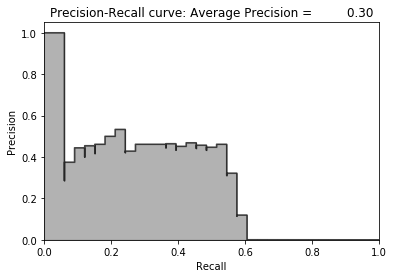

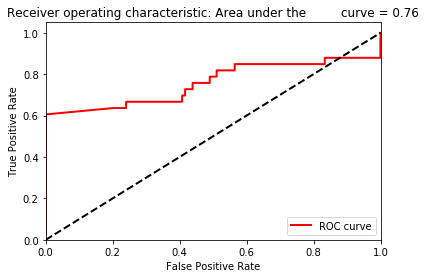

In [49]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

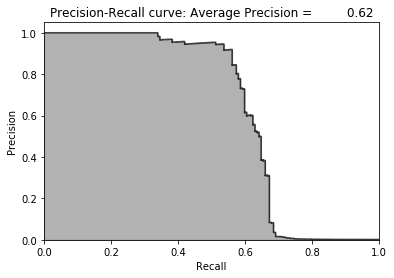

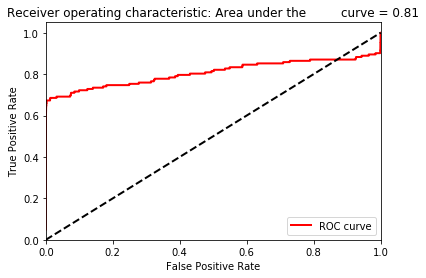

In [50]:
predictions = pd.Series(data=gbm.predict(X_test, \
                num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [51]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.004698601879440752


In [16]:
# Unsupervised

In [16]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [17]:
model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=29,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [18]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [19]:
num_epochs = 5
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Train on 155058 samples, validate on 38765 samples
Epoch 1/5
155058/155058 [==============================] - 16s 104us/step - loss: 0.1347 - acc: 0.8660 - val_loss: 0.1847 - val_acc: 0.9719
Epoch 2/5
155058/155058 [==============================] - 14s 91us/step - loss: 0.0515 - acc: 0.9246 - val_loss: 0.3361 - val_acc: 0.9587
Epoch 3/5
155058/155058 [==============================] - 15s 99us/step - loss: 0.0445 - acc: 0.9255 - val_loss: 0.1167 - val_acc: 0.9779
Epoch 4/5
155058/155058 [==============================] - 15s 100us/step - loss: 0.0408 - acc: 0.9249 - val_loss: 0.1459 - val_acc: 0.9531
Epoch 5/5
155058/155058 [==============================] - 14s 93us/step - loss: 0.0381 - acc: 0.9242 - val_loss: 0.0670 - val_acc: 0.9663


190523/190523 [==============================] - 3s 18us/step


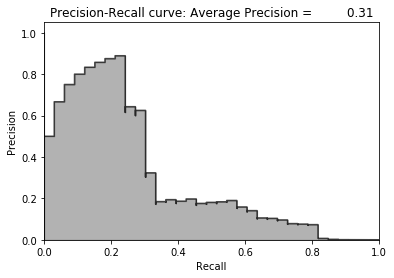

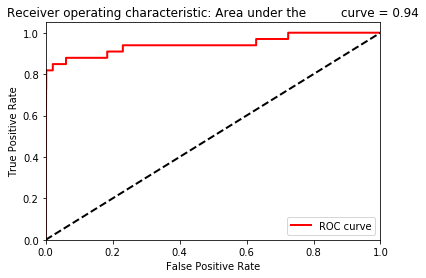

In [20]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, \
                                      anomalyScoresAETrain, True)

93987/93987 [==============================] - 1s 13us/step


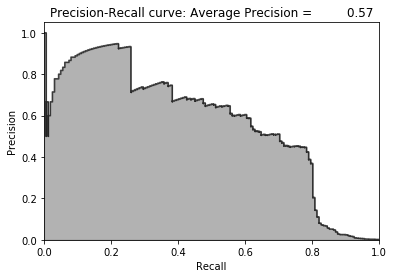

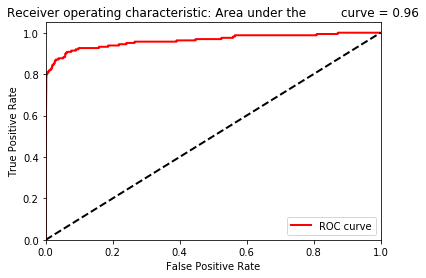

In [33]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [34]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.45387453874538747


In [25]:
# Semi-supervised

In [23]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, \
                                 outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test = intermediate_layer_model.predict(X_test_original)

In [24]:
intermediate_output_trainDF = \
    pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF = \
    pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

In [25]:
X_train = X_train_original.merge(intermediate_output_trainDF, \
                                 left_index=True,right_index=True)
X_test = X_test_original.merge(intermediate_output_testDF, \
                               left_index=True,right_index=True)
y_train = y_train_original.copy()

In [26]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, 
                                gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
                        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.0026001
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00195274
[3]	valid_0's binary_logloss: 0.00194893
[4]	valid_0's binary_logloss: 0.00194533
[5]	valid_0's binary_logloss: 0.0019298
[6]	valid_0's binary_logloss: 0.00192764
[7]	valid_0's binary_logloss: 0.00192773
[8]	valid_0's binary_logloss: 0.00192766
[9]	valid_0's binary_logloss: 0.0019276
[10]	valid_0's binary_logloss: 0.0019278
[11]	valid_0's binary_logloss: 0.00192776
[12]	valid_0's binary_logloss: 0.00192775
[13]	valid_0's binary_logloss: 0.00192792
[14]	valid_0's binary_logloss: 0.00192791
[15]	valid_0's binary_logloss: 0.00192679
[16]	valid_0's binary_logloss: 0.00194954
[17]	valid_0's binary_logloss: 0.00194901
[18]	valid_0's binary_logloss: 0.00194781
[19]	valid_0's binary_logloss: 0.00194705
[20]	valid_0's binary_logloss: 0.00194916
[21]	valid_0's binary_logloss: 0.00194777
[22]	valid_0's binary_logloss: 0.00194645
[23]	valid_0's binary_logl

[203]	valid_0's binary_logloss: 0.0018866
[204]	valid_0's binary_logloss: 0.00188693
[205]	valid_0's binary_logloss: 0.00188762
[206]	valid_0's binary_logloss: 0.00188831
[207]	valid_0's binary_logloss: 0.00188901
[208]	valid_0's binary_logloss: 0.0018895
[209]	valid_0's binary_logloss: 0.00189022
[210]	valid_0's binary_logloss: 0.00189035
[211]	valid_0's binary_logloss: 0.00189084
[212]	valid_0's binary_logloss: 0.0018912
[213]	valid_0's binary_logloss: 0.00189193
[214]	valid_0's binary_logloss: 0.00189267
[215]	valid_0's binary_logloss: 0.00189318
[216]	valid_0's binary_logloss: 0.00189392
[217]	valid_0's binary_logloss: 0.00189445
[218]	valid_0's binary_logloss: 0.0018952
[219]	valid_0's binary_logloss: 0.00189559
[220]	valid_0's binary_logloss: 0.00189578
[221]	valid_0's binary_logloss: 0.00189632
[222]	valid_0's binary_logloss: 0.00189709
[223]	valid_0's binary_logloss: 0.00189764
[224]	valid_0's binary_logloss: 0.00189842
[225]	valid_0's binary_logloss: 0.00189898
[226]	valid_0's

[40]	valid_0's binary_logloss: 0.000641939
[41]	valid_0's binary_logloss: 0.00063832
[42]	valid_0's binary_logloss: 0.000634938
[43]	valid_0's binary_logloss: 0.000630463
[44]	valid_0's binary_logloss: 0.000627733
[45]	valid_0's binary_logloss: 0.000623701
[46]	valid_0's binary_logloss: 0.000621336
[47]	valid_0's binary_logloss: 0.000618817
[48]	valid_0's binary_logloss: 0.000613745
[49]	valid_0's binary_logloss: 0.000611268
[50]	valid_0's binary_logloss: 0.000608854
[51]	valid_0's binary_logloss: 0.000606502
[52]	valid_0's binary_logloss: 0.000603366
[53]	valid_0's binary_logloss: 0.000600522
[54]	valid_0's binary_logloss: 0.000597768
[55]	valid_0's binary_logloss: 0.000595679
[56]	valid_0's binary_logloss: 0.00059295
[57]	valid_0's binary_logloss: 0.000590387
[58]	valid_0's binary_logloss: 0.000588461
[59]	valid_0's binary_logloss: 0.000586024
[60]	valid_0's binary_logloss: 0.00058355
[61]	valid_0's binary_logloss: 0.000580741
[62]	valid_0's binary_logloss: 0.000578398
[63]	valid_0's

[235]	valid_0's binary_logloss: 0.000502959
[236]	valid_0's binary_logloss: 0.000503027
[237]	valid_0's binary_logloss: 0.0005033
[238]	valid_0's binary_logloss: 0.000503279
[239]	valid_0's binary_logloss: 0.000503368
[240]	valid_0's binary_logloss: 0.000503515
[241]	valid_0's binary_logloss: 0.000503515
[242]	valid_0's binary_logloss: 0.000503811
[243]	valid_0's binary_logloss: 0.000503927
[244]	valid_0's binary_logloss: 0.000503947
[245]	valid_0's binary_logloss: 0.000504281
[246]	valid_0's binary_logloss: 0.000504416
[247]	valid_0's binary_logloss: 0.000504735
[248]	valid_0's binary_logloss: 0.000504779
[249]	valid_0's binary_logloss: 0.000504826
[250]	valid_0's binary_logloss: 0.000505181
[251]	valid_0's binary_logloss: 0.000505417
[252]	valid_0's binary_logloss: 0.000505589
[253]	valid_0's binary_logloss: 0.000505761
[254]	valid_0's binary_logloss: 0.000505833
[255]	valid_0's binary_logloss: 0.000506051
[256]	valid_0's binary_logloss: 0.000506404
[257]	valid_0's binary_logloss: 0.

[74]	valid_0's binary_logloss: 0.00570266
[75]	valid_0's binary_logloss: 0.00570138
[76]	valid_0's binary_logloss: 0.00569968
[77]	valid_0's binary_logloss: 0.0056984
[78]	valid_0's binary_logloss: 0.00569714
[79]	valid_0's binary_logloss: 0.00569586
[80]	valid_0's binary_logloss: 0.00569465
[81]	valid_0's binary_logloss: 0.00569347
[82]	valid_0's binary_logloss: 0.00569237
[83]	valid_0's binary_logloss: 0.0056913
[84]	valid_0's binary_logloss: 0.00569028
[85]	valid_0's binary_logloss: 0.00568855
[86]	valid_0's binary_logloss: 0.00568717
[87]	valid_0's binary_logloss: 0.00568514
[88]	valid_0's binary_logloss: 0.0056838
[89]	valid_0's binary_logloss: 0.00568183
[90]	valid_0's binary_logloss: 0.00568056
[91]	valid_0's binary_logloss: 0.00567863
[92]	valid_0's binary_logloss: 0.00567741
[93]	valid_0's binary_logloss: 0.00567549
[94]	valid_0's binary_logloss: 0.00567429
[95]	valid_0's binary_logloss: 0.00567309
[96]	valid_0's binary_logloss: 0.00567194
[97]	valid_0's binary_logloss: 0.0056

[63]	valid_0's binary_logloss: 0.000778716
[64]	valid_0's binary_logloss: 0.000778543
[65]	valid_0's binary_logloss: 0.000778304
[66]	valid_0's binary_logloss: 0.000778129
[67]	valid_0's binary_logloss: 0.000777939
[68]	valid_0's binary_logloss: 0.000777793
[69]	valid_0's binary_logloss: 0.000777723
[70]	valid_0's binary_logloss: 0.000777597
[71]	valid_0's binary_logloss: 0.00077755
[72]	valid_0's binary_logloss: 0.000777427
[73]	valid_0's binary_logloss: 0.000777354
[74]	valid_0's binary_logloss: 0.000777323
[75]	valid_0's binary_logloss: 0.000777288
[76]	valid_0's binary_logloss: 0.000777248
[77]	valid_0's binary_logloss: 0.00077721
[78]	valid_0's binary_logloss: 0.000777253
[79]	valid_0's binary_logloss: 0.000777261
[80]	valid_0's binary_logloss: 0.000777308
[81]	valid_0's binary_logloss: 0.000777331
[82]	valid_0's binary_logloss: 0.000777417
[83]	valid_0's binary_logloss: 0.000777502
[84]	valid_0's binary_logloss: 0.000777662
[85]	valid_0's binary_logloss: 0.00077775
[86]	valid_0's

[166]	valid_0's binary_logloss: 0.00179968
[167]	valid_0's binary_logloss: 0.00179801
[168]	valid_0's binary_logloss: 0.00179635
[169]	valid_0's binary_logloss: 0.00179471
[170]	valid_0's binary_logloss: 0.00179307
[171]	valid_0's binary_logloss: 0.00179145
[172]	valid_0's binary_logloss: 0.00179025
[173]	valid_0's binary_logloss: 0.00178865
[174]	valid_0's binary_logloss: 0.00178731
[175]	valid_0's binary_logloss: 0.00178579
[176]	valid_0's binary_logloss: 0.00178428
[177]	valid_0's binary_logloss: 0.00178278
[178]	valid_0's binary_logloss: 0.00178129
[179]	valid_0's binary_logloss: 0.00178014
[180]	valid_0's binary_logloss: 0.00177885
[181]	valid_0's binary_logloss: 0.00177739
[182]	valid_0's binary_logloss: 0.00177592
[183]	valid_0's binary_logloss: 0.00177448
[184]	valid_0's binary_logloss: 0.00177321
[185]	valid_0's binary_logloss: 0.00177209
[186]	valid_0's binary_logloss: 0.00177067
[187]	valid_0's binary_logloss: 0.00176924
[188]	valid_0's binary_logloss: 0.00176782
[189]	valid

[363]	valid_0's binary_logloss: 0.00166784
[364]	valid_0's binary_logloss: 0.00166653
[365]	valid_0's binary_logloss: 0.00166641
[366]	valid_0's binary_logloss: 0.00166674
[367]	valid_0's binary_logloss: 0.00166609
[368]	valid_0's binary_logloss: 0.00166642
[369]	valid_0's binary_logloss: 0.00166629
[370]	valid_0's binary_logloss: 0.00166571
[371]	valid_0's binary_logloss: 0.00166507
[372]	valid_0's binary_logloss: 0.00166474
[373]	valid_0's binary_logloss: 0.00166508
[374]	valid_0's binary_logloss: 0.00166495
[375]	valid_0's binary_logloss: 0.00166477
[376]	valid_0's binary_logloss: 0.00166457
[377]	valid_0's binary_logloss: 0.00166394
[378]	valid_0's binary_logloss: 0.00166338
[379]	valid_0's binary_logloss: 0.00166319
[380]	valid_0's binary_logloss: 0.00166307
[381]	valid_0's binary_logloss: 0.00166244
[382]	valid_0's binary_logloss: 0.0016616
[383]	valid_0's binary_logloss: 0.00166142
[384]	valid_0's binary_logloss: 0.00166125
[385]	valid_0's binary_logloss: 0.00166069
[386]	valid_

[557]	valid_0's binary_logloss: 0.00156499
[558]	valid_0's binary_logloss: 0.00156391
[559]	valid_0's binary_logloss: 0.00156362
[560]	valid_0's binary_logloss: 0.00156267
[561]	valid_0's binary_logloss: 0.00156262
[562]	valid_0's binary_logloss: 0.00156288
[563]	valid_0's binary_logloss: 0.00156172
[564]	valid_0's binary_logloss: 0.00156147
[565]	valid_0's binary_logloss: 0.00156039
[566]	valid_0's binary_logloss: 0.00155944
[567]	valid_0's binary_logloss: 0.00155913
[568]	valid_0's binary_logloss: 0.00155818
[569]	valid_0's binary_logloss: 0.00155702
[570]	valid_0's binary_logloss: 0.00155588
[571]	valid_0's binary_logloss: 0.00155614
[572]	valid_0's binary_logloss: 0.0015552
[573]	valid_0's binary_logloss: 0.00155495
[574]	valid_0's binary_logloss: 0.00155417
[575]	valid_0's binary_logloss: 0.00155323
[576]	valid_0's binary_logloss: 0.00155181
[577]	valid_0's binary_logloss: 0.00155182
[578]	valid_0's binary_logloss: 0.00155208
[579]	valid_0's binary_logloss: 0.001551
[580]	valid_0'

[940]	valid_0's binary_logloss: 0.0013765
[941]	valid_0's binary_logloss: 0.00137605
[942]	valid_0's binary_logloss: 0.00137509
[943]	valid_0's binary_logloss: 0.00137489
[944]	valid_0's binary_logloss: 0.00137419
[945]	valid_0's binary_logloss: 0.00137356
[946]	valid_0's binary_logloss: 0.00137246
[947]	valid_0's binary_logloss: 0.00137202
[948]	valid_0's binary_logloss: 0.00137132
[949]	valid_0's binary_logloss: 0.0013707
[950]	valid_0's binary_logloss: 0.00137024
[951]	valid_0's binary_logloss: 0.00136979
[952]	valid_0's binary_logloss: 0.00136917
[953]	valid_0's binary_logloss: 0.00136863
[954]	valid_0's binary_logloss: 0.00136801
[955]	valid_0's binary_logloss: 0.00136747
[956]	valid_0's binary_logloss: 0.00136802
[957]	valid_0's binary_logloss: 0.00136757
[958]	valid_0's binary_logloss: 0.00136737
[959]	valid_0's binary_logloss: 0.00136804
[960]	valid_0's binary_logloss: 0.0013675
[961]	valid_0's binary_logloss: 0.00136656
[962]	valid_0's binary_logloss: 0.00136636
[963]	valid_0'

[1131]	valid_0's binary_logloss: 0.00131895
[1132]	valid_0's binary_logloss: 0.0013188
[1133]	valid_0's binary_logloss: 0.001319
[1134]	valid_0's binary_logloss: 0.00131857
[1135]	valid_0's binary_logloss: 0.00131841
[1136]	valid_0's binary_logloss: 0.001318
[1137]	valid_0's binary_logloss: 0.00131794
[1138]	valid_0's binary_logloss: 0.00131734
[1139]	valid_0's binary_logloss: 0.00131784
[1140]	valid_0's binary_logloss: 0.00131768
[1141]	valid_0's binary_logloss: 0.00131682
[1142]	valid_0's binary_logloss: 0.00131666
[1143]	valid_0's binary_logloss: 0.00131687
[1144]	valid_0's binary_logloss: 0.00131641
[1145]	valid_0's binary_logloss: 0.00131641
[1146]	valid_0's binary_logloss: 0.00131691
[1147]	valid_0's binary_logloss: 0.00131674
[1148]	valid_0's binary_logloss: 0.00131658
[1149]	valid_0's binary_logloss: 0.00131585
[1150]	valid_0's binary_logloss: 0.0013157
[1151]	valid_0's binary_logloss: 0.0013159
[1152]	valid_0's binary_logloss: 0.00131531
[1153]	valid_0's binary_logloss: 0.0013

[1318]	valid_0's binary_logloss: 0.00128942
[1319]	valid_0's binary_logloss: 0.00128958
[1320]	valid_0's binary_logloss: 0.00128876
[1321]	valid_0's binary_logloss: 0.00128904
[1322]	valid_0's binary_logloss: 0.00128856
[1323]	valid_0's binary_logloss: 0.00128774
[1324]	valid_0's binary_logloss: 0.00128793
[1325]	valid_0's binary_logloss: 0.00128741
[1326]	valid_0's binary_logloss: 0.00128771
[1327]	valid_0's binary_logloss: 0.00128695
[1328]	valid_0's binary_logloss: 0.00128691
[1329]	valid_0's binary_logloss: 0.00128657
[1330]	valid_0's binary_logloss: 0.00128645
[1331]	valid_0's binary_logloss: 0.00128668
[1332]	valid_0's binary_logloss: 0.00128694
[1333]	valid_0's binary_logloss: 0.00128682
[1334]	valid_0's binary_logloss: 0.00128712
[1335]	valid_0's binary_logloss: 0.0012874
[1336]	valid_0's binary_logloss: 0.00128685
[1337]	valid_0's binary_logloss: 0.00128711
[1338]	valid_0's binary_logloss: 0.00128741
[1339]	valid_0's binary_logloss: 0.0012873
[1340]	valid_0's binary_logloss: 0

[1509]	valid_0's binary_logloss: 0.00126893
[1510]	valid_0's binary_logloss: 0.00126833
[1511]	valid_0's binary_logloss: 0.0012686
[1512]	valid_0's binary_logloss: 0.00126865
[1513]	valid_0's binary_logloss: 0.00126847
[1514]	valid_0's binary_logloss: 0.00126874
[1515]	valid_0's binary_logloss: 0.00126815
[1516]	valid_0's binary_logloss: 0.00126798
[1517]	valid_0's binary_logloss: 0.00126778
[1518]	valid_0's binary_logloss: 0.00126788
[1519]	valid_0's binary_logloss: 0.00126803
[1520]	valid_0's binary_logloss: 0.00126767
[1521]	valid_0's binary_logloss: 0.00126785
[1522]	valid_0's binary_logloss: 0.00126726
[1523]	valid_0's binary_logloss: 0.00126736
[1524]	valid_0's binary_logloss: 0.001267
[1525]	valid_0's binary_logloss: 0.00126692
[1526]	valid_0's binary_logloss: 0.00126707
[1527]	valid_0's binary_logloss: 0.0012673
[1528]	valid_0's binary_logloss: 0.00126672
[1529]	valid_0's binary_logloss: 0.00126636
[1530]	valid_0's binary_logloss: 0.00126659
[1531]	valid_0's binary_logloss: 0.0

[1697]	valid_0's binary_logloss: 0.0012546
[1698]	valid_0's binary_logloss: 0.00125463
[1699]	valid_0's binary_logloss: 0.00125459
[1700]	valid_0's binary_logloss: 0.0012548
[1701]	valid_0's binary_logloss: 0.00125476
[1702]	valid_0's binary_logloss: 0.00125498
[1703]	valid_0's binary_logloss: 0.0012549
[1704]	valid_0's binary_logloss: 0.00125493
[1705]	valid_0's binary_logloss: 0.0012549
[1706]	valid_0's binary_logloss: 0.00125482
[1707]	valid_0's binary_logloss: 0.00125474
[1708]	valid_0's binary_logloss: 0.00125475
[1709]	valid_0's binary_logloss: 0.00125471
[1710]	valid_0's binary_logloss: 0.00125474
[1711]	valid_0's binary_logloss: 0.00125445
[1712]	valid_0's binary_logloss: 0.00125442
[1713]	valid_0's binary_logloss: 0.00125464
[1714]	valid_0's binary_logloss: 0.00125485
[1715]	valid_0's binary_logloss: 0.00125477
[1716]	valid_0's binary_logloss: 0.00125498
[1717]	valid_0's binary_logloss: 0.00125478
[1718]	valid_0's binary_logloss: 0.00125475
[1719]	valid_0's binary_logloss: 0.0

[1885]	valid_0's binary_logloss: 0.00125134
[1886]	valid_0's binary_logloss: 0.00125117
[1887]	valid_0's binary_logloss: 0.00125104
[1888]	valid_0's binary_logloss: 0.00125101
[1889]	valid_0's binary_logloss: 0.00125121
[1890]	valid_0's binary_logloss: 0.00125118
[1891]	valid_0's binary_logloss: 0.00125112
[1892]	valid_0's binary_logloss: 0.00125106
[1893]	valid_0's binary_logloss: 0.00125103
[1894]	valid_0's binary_logloss: 0.00125102
[1895]	valid_0's binary_logloss: 0.00125123
[1896]	valid_0's binary_logloss: 0.00125128
[1897]	valid_0's binary_logloss: 0.00125104
[1898]	valid_0's binary_logloss: 0.00125101
[1899]	valid_0's binary_logloss: 0.00125096
[1900]	valid_0's binary_logloss: 0.00125093
[1901]	valid_0's binary_logloss: 0.00125092
[1902]	valid_0's binary_logloss: 0.00125089
[1903]	valid_0's binary_logloss: 0.00125084
[1904]	valid_0's binary_logloss: 0.0012509
[1905]	valid_0's binary_logloss: 0.00125087
[1906]	valid_0's binary_logloss: 0.00125055
[1907]	valid_0's binary_logloss: 

[2081]	valid_0's binary_logloss: 0.00124673
[2082]	valid_0's binary_logloss: 0.00124671
[2083]	valid_0's binary_logloss: 0.00124667
[2084]	valid_0's binary_logloss: 0.00124662
[2085]	valid_0's binary_logloss: 0.00124659
[2086]	valid_0's binary_logloss: 0.0012466
[2087]	valid_0's binary_logloss: 0.00124667
[2088]	valid_0's binary_logloss: 0.00124643
[2089]	valid_0's binary_logloss: 0.00124662
[2090]	valid_0's binary_logloss: 0.00124663
[2091]	valid_0's binary_logloss: 0.00124658
[2092]	valid_0's binary_logloss: 0.00124652
[2093]	valid_0's binary_logloss: 0.00124651
[2094]	valid_0's binary_logloss: 0.00124648
[2095]	valid_0's binary_logloss: 0.00124645
[2096]	valid_0's binary_logloss: 0.00124627
[2097]	valid_0's binary_logloss: 0.00124625
[2098]	valid_0's binary_logloss: 0.00124622
[2099]	valid_0's binary_logloss: 0.00124623
[2100]	valid_0's binary_logloss: 0.0012462
[2101]	valid_0's binary_logloss: 0.00124615
[2102]	valid_0's binary_logloss: 0.00124617
[2103]	valid_0's binary_logloss: 0

[2277]	valid_0's binary_logloss: 0.00124309
[2278]	valid_0's binary_logloss: 0.00124298
[2279]	valid_0's binary_logloss: 0.00124299
[2280]	valid_0's binary_logloss: 0.00124298
[2281]	valid_0's binary_logloss: 0.00124299
[2282]	valid_0's binary_logloss: 0.00124296
[2283]	valid_0's binary_logloss: 0.00124285
[2284]	valid_0's binary_logloss: 0.0012428
[2285]	valid_0's binary_logloss: 0.00124287
[2286]	valid_0's binary_logloss: 0.00124284
[2287]	valid_0's binary_logloss: 0.00124286
[2288]	valid_0's binary_logloss: 0.00124287
[2289]	valid_0's binary_logloss: 0.00124286
[2290]	valid_0's binary_logloss: 0.00124287
[2291]	valid_0's binary_logloss: 0.00124294
[2292]	valid_0's binary_logloss: 0.00124283
[2293]	valid_0's binary_logloss: 0.00124273
[2294]	valid_0's binary_logloss: 0.00124267
[2295]	valid_0's binary_logloss: 0.00124262
[2296]	valid_0's binary_logloss: 0.00124255
[2297]	valid_0's binary_logloss: 0.00124252
[2298]	valid_0's binary_logloss: 0.00124253
[2299]	valid_0's binary_logloss: 

[2464]	valid_0's binary_logloss: 0.00123933
[2465]	valid_0's binary_logloss: 0.00123939
[2466]	valid_0's binary_logloss: 0.00123929
[2467]	valid_0's binary_logloss: 0.00123927
[2468]	valid_0's binary_logloss: 0.00123921
[2469]	valid_0's binary_logloss: 0.00123922
[2470]	valid_0's binary_logloss: 0.00123917
[2471]	valid_0's binary_logloss: 0.00123915
[2472]	valid_0's binary_logloss: 0.00123913
[2473]	valid_0's binary_logloss: 0.00123908
[2474]	valid_0's binary_logloss: 0.00123909
[2475]	valid_0's binary_logloss: 0.00123906
[2476]	valid_0's binary_logloss: 0.00123907
[2477]	valid_0's binary_logloss: 0.00123897
[2478]	valid_0's binary_logloss: 0.00123898
[2479]	valid_0's binary_logloss: 0.00123904
[2480]	valid_0's binary_logloss: 0.00123894
[2481]	valid_0's binary_logloss: 0.00123893
[2482]	valid_0's binary_logloss: 0.00123895
[2483]	valid_0's binary_logloss: 0.00123884
[2484]	valid_0's binary_logloss: 0.00123882
[2485]	valid_0's binary_logloss: 0.00123883
[2486]	valid_0's binary_logloss:

[2655]	valid_0's binary_logloss: 0.00123561
[2656]	valid_0's binary_logloss: 0.00123551
[2657]	valid_0's binary_logloss: 0.00123557
[2658]	valid_0's binary_logloss: 0.00123552
[2659]	valid_0's binary_logloss: 0.0012355
[2660]	valid_0's binary_logloss: 0.00123548
[2661]	valid_0's binary_logloss: 0.0012355
[2662]	valid_0's binary_logloss: 0.0012354
[2663]	valid_0's binary_logloss: 0.00123538
[2664]	valid_0's binary_logloss: 0.00123545
[2665]	valid_0's binary_logloss: 0.00123543
[2666]	valid_0's binary_logloss: 0.00123533
[2667]	valid_0's binary_logloss: 0.00123533
[2668]	valid_0's binary_logloss: 0.00123524
[2669]	valid_0's binary_logloss: 0.00123525
[2670]	valid_0's binary_logloss: 0.00123519
[2671]	valid_0's binary_logloss: 0.00123517
[2672]	valid_0's binary_logloss: 0.00123517
[2673]	valid_0's binary_logloss: 0.00123516
[2674]	valid_0's binary_logloss: 0.00123511
[2675]	valid_0's binary_logloss: 0.00123506
[2676]	valid_0's binary_logloss: 0.00123506
[2677]	valid_0's binary_logloss: 0.

[2842]	valid_0's binary_logloss: 0.00123242
[2843]	valid_0's binary_logloss: 0.00123237
[2844]	valid_0's binary_logloss: 0.00123238
[2845]	valid_0's binary_logloss: 0.00123235
[2846]	valid_0's binary_logloss: 0.00123236
[2847]	valid_0's binary_logloss: 0.00123234
[2848]	valid_0's binary_logloss: 0.00123236
[2849]	valid_0's binary_logloss: 0.00123226
[2850]	valid_0's binary_logloss: 0.00123233
[2851]	valid_0's binary_logloss: 0.00123239
[2852]	valid_0's binary_logloss: 0.0012323
[2853]	valid_0's binary_logloss: 0.00123229
[2854]	valid_0's binary_logloss: 0.00123229
[2855]	valid_0's binary_logloss: 0.00123228
[2856]	valid_0's binary_logloss: 0.00123223
[2857]	valid_0's binary_logloss: 0.00123218
[2858]	valid_0's binary_logloss: 0.00123216
[2859]	valid_0's binary_logloss: 0.00123206
[2860]	valid_0's binary_logloss: 0.00123216
[2861]	valid_0's binary_logloss: 0.00123206
[2862]	valid_0's binary_logloss: 0.00123204
[2863]	valid_0's binary_logloss: 0.00123204
[2864]	valid_0's binary_logloss: 

[3042]	valid_0's binary_logloss: 0.00122974
[3043]	valid_0's binary_logloss: 0.00122966
[3044]	valid_0's binary_logloss: 0.00122964
[3045]	valid_0's binary_logloss: 0.00122969
[3046]	valid_0's binary_logloss: 0.00122976
[3047]	valid_0's binary_logloss: 0.00122974
[3048]	valid_0's binary_logloss: 0.00122968
[3049]	valid_0's binary_logloss: 0.00122963
[3050]	valid_0's binary_logloss: 0.00122962
[3051]	valid_0's binary_logloss: 0.00122963
[3052]	valid_0's binary_logloss: 0.00122961
[3053]	valid_0's binary_logloss: 0.0012297
[3054]	valid_0's binary_logloss: 0.00122961
[3055]	valid_0's binary_logloss: 0.00122958
[3056]	valid_0's binary_logloss: 0.00122959
[3057]	valid_0's binary_logloss: 0.00122957
[3058]	valid_0's binary_logloss: 0.00122959
[3059]	valid_0's binary_logloss: 0.00122954
[3060]	valid_0's binary_logloss: 0.00122944
[3061]	valid_0's binary_logloss: 0.00122943
[3062]	valid_0's binary_logloss: 0.00122944
[3063]	valid_0's binary_logloss: 0.00122954
[3064]	valid_0's binary_logloss: 

[3236]	valid_0's binary_logloss: 0.00122747
[3237]	valid_0's binary_logloss: 0.00122745
[3238]	valid_0's binary_logloss: 0.00122745
[3239]	valid_0's binary_logloss: 0.00122754
[3240]	valid_0's binary_logloss: 0.00122746
[3241]	valid_0's binary_logloss: 0.00122747
[3242]	valid_0's binary_logloss: 0.00122753
[3243]	valid_0's binary_logloss: 0.00122751
[3244]	valid_0's binary_logloss: 0.00122746
[3245]	valid_0's binary_logloss: 0.0012274
[3246]	valid_0's binary_logloss: 0.00122731
[3247]	valid_0's binary_logloss: 0.00122729
[3248]	valid_0's binary_logloss: 0.00122731
[3249]	valid_0's binary_logloss: 0.00122722
[3250]	valid_0's binary_logloss: 0.00122723
[3251]	valid_0's binary_logloss: 0.00122722
[3252]	valid_0's binary_logloss: 0.00122713
[3253]	valid_0's binary_logloss: 0.00122722
[3254]	valid_0's binary_logloss: 0.00122721
[3255]	valid_0's binary_logloss: 0.00122722
[3256]	valid_0's binary_logloss: 0.0012272
[3257]	valid_0's binary_logloss: 0.00122719
[3258]	valid_0's binary_logloss: 0

[3424]	valid_0's binary_logloss: 0.00122416
[3425]	valid_0's binary_logloss: 0.00122415
[3426]	valid_0's binary_logloss: 0.00122424
[3427]	valid_0's binary_logloss: 0.00122416
[3428]	valid_0's binary_logloss: 0.00122417
[3429]	valid_0's binary_logloss: 0.00122419
[3430]	valid_0's binary_logloss: 0.00122417
[3431]	valid_0's binary_logloss: 0.00122408
[3432]	valid_0's binary_logloss: 0.00122407
[3433]	valid_0's binary_logloss: 0.00122405
[3434]	valid_0's binary_logloss: 0.00122407
[3435]	valid_0's binary_logloss: 0.00122402
[3436]	valid_0's binary_logloss: 0.00122393
[3437]	valid_0's binary_logloss: 0.00122391
[3438]	valid_0's binary_logloss: 0.001224
[3439]	valid_0's binary_logloss: 0.00122392
[3440]	valid_0's binary_logloss: 0.0012239
[3441]	valid_0's binary_logloss: 0.00122389
[3442]	valid_0's binary_logloss: 0.0012239
[3443]	valid_0's binary_logloss: 0.00122388
[3444]	valid_0's binary_logloss: 0.00122383
[3445]	valid_0's binary_logloss: 0.00122385
[3446]	valid_0's binary_logloss: 0.0

[3620]	valid_0's binary_logloss: 0.0012215
[3621]	valid_0's binary_logloss: 0.00122142
[3622]	valid_0's binary_logloss: 0.0012214
[3623]	valid_0's binary_logloss: 0.00122138
[3624]	valid_0's binary_logloss: 0.00122137
[3625]	valid_0's binary_logloss: 0.00122132
[3626]	valid_0's binary_logloss: 0.00122132
[3627]	valid_0's binary_logloss: 0.0012213
[3628]	valid_0's binary_logloss: 0.00122143
[3629]	valid_0's binary_logloss: 0.00122134
[3630]	valid_0's binary_logloss: 0.00122141
[3631]	valid_0's binary_logloss: 0.00122133
[3632]	valid_0's binary_logloss: 0.00122133
[3633]	valid_0's binary_logloss: 0.00122128
[3634]	valid_0's binary_logloss: 0.00122126
[3635]	valid_0's binary_logloss: 0.00122135
[3636]	valid_0's binary_logloss: 0.00122134
[3637]	valid_0's binary_logloss: 0.0012214
[3638]	valid_0's binary_logloss: 0.00122141
[3639]	valid_0's binary_logloss: 0.00122143
[3640]	valid_0's binary_logloss: 0.00122134
[3641]	valid_0's binary_logloss: 0.00122135
[3642]	valid_0's binary_logloss: 0.0

[3807]	valid_0's binary_logloss: 0.00122079
[3808]	valid_0's binary_logloss: 0.0012207
[3809]	valid_0's binary_logloss: 0.00122083
[3810]	valid_0's binary_logloss: 0.00122084
[3811]	valid_0's binary_logloss: 0.00122082
[3812]	valid_0's binary_logloss: 0.00122091
[3813]	valid_0's binary_logloss: 0.00122083
[3814]	valid_0's binary_logloss: 0.00122082
[3815]	valid_0's binary_logloss: 0.00122081
[3816]	valid_0's binary_logloss: 0.00122082
[3817]	valid_0's binary_logloss: 0.0012209
[3818]	valid_0's binary_logloss: 0.00122082
[3819]	valid_0's binary_logloss: 0.00122081
[3820]	valid_0's binary_logloss: 0.00122087
[3821]	valid_0's binary_logloss: 0.00122088
[3822]	valid_0's binary_logloss: 0.00122086
[3823]	valid_0's binary_logloss: 0.00122081
[3824]	valid_0's binary_logloss: 0.00122081
[3825]	valid_0's binary_logloss: 0.0012208
[3826]	valid_0's binary_logloss: 0.00122088
[3827]	valid_0's binary_logloss: 0.00122087
[3828]	valid_0's binary_logloss: 0.00122092
[3829]	valid_0's binary_logloss: 0.

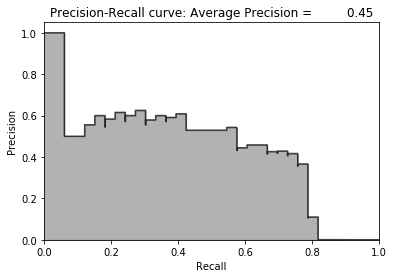

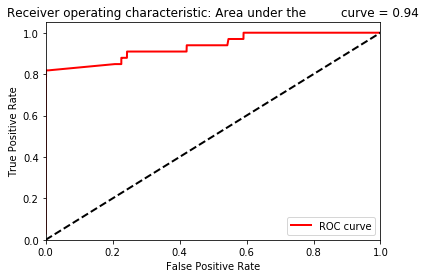

In [27]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

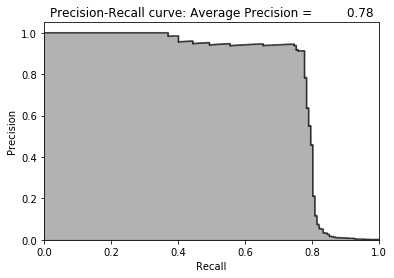

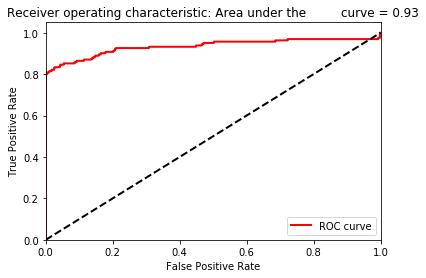

In [28]:
predictions = pd.Series(data=gbm.predict(X_test, \
                    num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [31]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

0.917910447761194


In [30]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), \
                        index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', \
                               ascending=False,inplace=True)
featuresImportance

,featImportance
V28,0.047843
Amount,0.037263
21,0.030244
V21,0.029624
V26,0.029469
V12,0.028334
V27,0.028024
6,0.027405
28,0.026941
36,0.024050
